<a href="https://colab.research.google.com/github/aapte11/DS-Sprint-01-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [89]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [90]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [91]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=123.67902932375785, mobile=True), User(purchased=True, time_on_site=230.68049285141808, mobile=True), User(purchased=False, time_on_site=91.02250038853381, mobile=True), User(purchased=False, time_on_site=205.03515882897167, mobile=True), User(purchased=True, time_on_site=51.15115334058209, mobile=True), User(purchased=False, time_on_site=86.59247033853603, mobile=True), User(purchased=False, time_on_site=512.3224858561633, mobile=False), User(purchased=False, time_on_site=138.707523278344, mobile=True), User(purchased=False, time_on_site=8.790970552158178, mobile=True), User(purchased=False, time_on_site=205.79782525265406, mobile=False)]


In [92]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,123.679029,True
1,True,230.680493,True
2,False,91.022500,True
3,False,205.035159,True
4,True,51.151153,True


In [93]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,6.3451918398111,6.492606630409261,8.032439828429979,8.09459718852441,8.318894342431857,8.790970552158178,9.451190601341008,9.518921428668008,9.585367449055617,10.10452171129188,...,587.1893978785058,591.0893100515395,591.7400510189872,591.9996308610505,592.2403511484109,593.6483254670937,596.81246904532,597.006272892826,598.0983794505038,599.6549560647981
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,0,1,1,1,1,1,1,1,0,...,1,1,0,0,1,1,1,1,0,1
True,1,1,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0


In [94]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.752, 125.007]","(125.007, 243.669]","(243.669, 362.331]","(362.331, 480.993]","(480.993, 599.655]"
purchased,,,,,
False,294,289,154,38,48
True,68,76,25,0,8


In [95]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='all')

time_on_site,"(5.752, 125.007]","(125.007, 243.669]","(243.669, 362.331]","(362.331, 480.993]","(480.993, 599.655]"
purchased,,,,,
False,0.294,0.289,0.154,0.038,0.048
True,0.068,0.076,0.025,0.000,0.008


In [96]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='all')

mobile,False,True
purchased,,
False,0.232,0.591
True,0.018,0.159


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

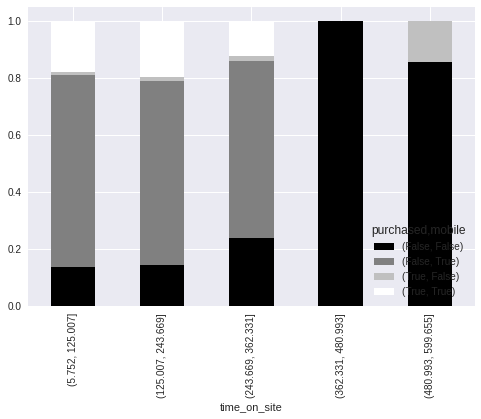

In [98]:
my_colors = ['k','gray','silver','w']

pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='index').plot(kind = 'bar', stacked = True, color = my_colors)

# Normalizing by index makes interpretation of the y axis make sense. 

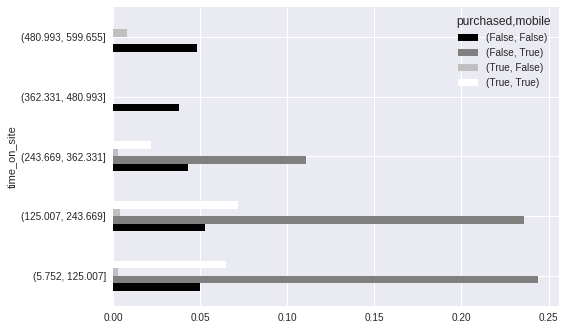

In [99]:
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='all').plot(kind = 'barh', stacked = False, color = my_colors)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [100]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

# path = 'DS-Sprint-01-Dealing-With-Data/module4-databackedassertions/persons.csv' XXX
# path_alt = 'https://github.com/aapte11/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/persons.csv' XXX

path_alt2 = 'https://raw.githubusercontent.com/aapte11/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'

# Always upload from raw file
      
df_persons = pd.read_csv(path_alt2, index_col=0)

df_persons.head()


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


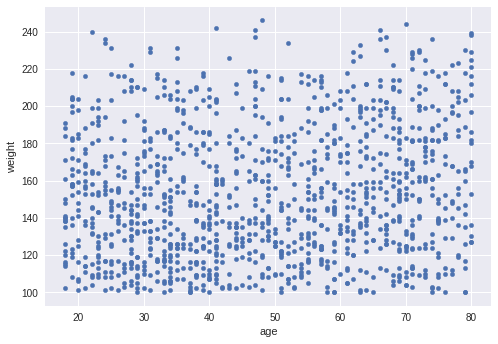

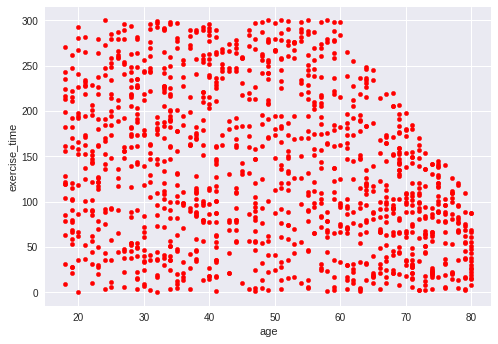

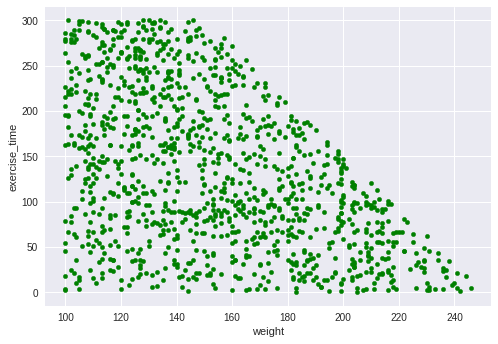

In [101]:
df_persons.plot.scatter('age', 'weight')
df_persons.plot.scatter('age', 'exercise_time', color = 'r')
df_persons.plot.scatter('weight','exercise_time', color = 'g')

In [102]:
df_persons.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


In [103]:
print(df_persons.age.unique())
print (df_persons.weight.unique())
print (df_persons.exercise_time.unique())



[44 41 46 39 28 58 55 21 50 43 73 27 36 49 69 18 19 34 20 32 71 79 72 26
 29 40 78 70 61 35 80 63 74 52 23 60 47 53 31 68 64 51 30 33 57 37 66 45
 56 38 59 75 67 24 62 25 65 76 48 22 42 54 77]
[118 161 128 216 116 103 188 127 160 102 209 165 169 131 171 172 122 157
 218 143 159 117 164 189 149 168 208 163 133 145 158 138 200 112 186 211
 152 140 136 192 120 193 109 134 244 101 170 153 142 154 231 207 130 137
 113 198 100 199 214 156 173 119 114 213 108 205 187 125 147 177 110 139
 176 129 191 180 182 162 206 106 237 236 174 229 183 155 203 204 148 123
 225 221 124 219 202 150 104 223 210 226 135 151 126 238 141 107 146 220
 181 105 121 115 185 111 197 166 212 144 215 132 190 195 194 175 184 178
 167 239 234 222 196 179 233 230 228 201 217 240 246 241 224 242 227]
[192  35 220  57 182 165 107  37  79 267 228  78  44  48 171 194 191 147
 271 111  28  24 241 181  21 229  38 110 279  91 115  67 172 175 164  63
 159 270  87 100 151  83 187  75   6 264  71 280 162  18 105 259  43  25
 225 21

In [0]:
age_bins = pd.cut(df_persons.age, 5)
weight_bins = pd.cut(df_persons.weight, 5)
exer_bins = pd.cut(df_persons.exercise_time, 5)

import seaborn as sns

df1 = pd.crosstab(age_bins, weight_bins, normalize = 'all')
df2 = pd.crosstab(age_bins, exer_bins, normalize='all')
df3 = pd.crosstab(exer_bins, weight_bins, normalize='all')




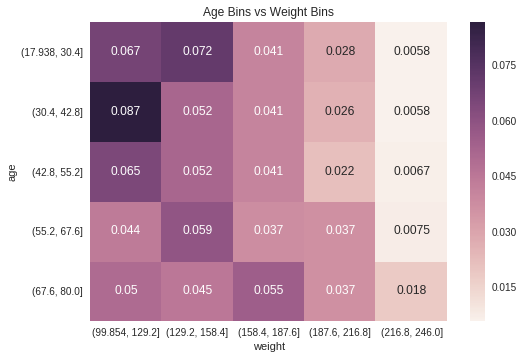

In [105]:
sns.heatmap(df1, annot=True).set_title('Age Bins vs Weight Bins');

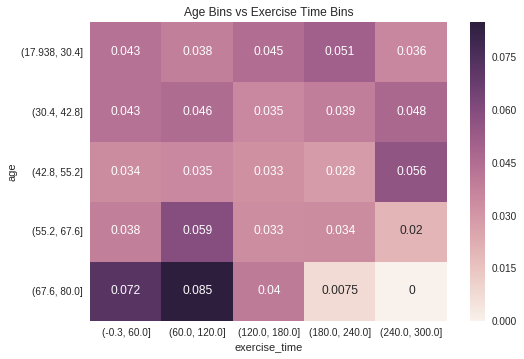

In [106]:
sns.heatmap(df2, annot=True).set_title('Age Bins vs Exercise Time Bins');

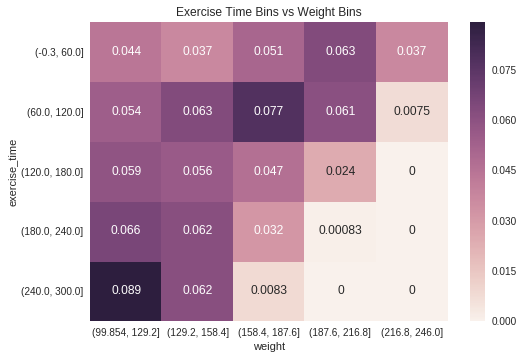

In [107]:
sns.heatmap(df3, annot=True).set_title('Exercise Time Bins vs Weight Bins');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

**Age, weight and exercise time are all continuous variables even though in this dataset they seem to be put into bins.**


2.  What are the relationships between the variables?

**Age and weight have aa weak positive relationship. Exercise time and age have a negative relationship and exercise time and weight have a strongly negative relationship. **

3.  Which relationships are "real", and which spurious?

**From a conceptual standpoint, it seems as if weight and/or exercise time is a function of age as age is a given variable (can't change age) while the other two are variable. However when looking at the correlation matrix, one sees that the strongest relationship is between exercise time and weight. However, one feels it is necessary to bin the data and to put it into heatmaps to see where the relaationships are strongest as the original scatterplots suggest varying degrees of strength throughout the plot. **


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

**Monthly Milk Production vs S&P 500 1962-1975**

In [108]:
urlsnp = 'https://raw.githubusercontent.com/aapte11/DS-Sprint-01-Dealing-With-Data/master/S%26P500MonthlyReturns.csv'
urlmilk = 'https://raw.githubusercontent.com/aapte11/DS-Sprint-01-Dealing-With-Data/master/monthly-milk-production-pounds-p.csv'

df_snp = pd.read_csv(urlsnp)
df_milk = pd.read_csv(urlmilk)

print(df_snp.head())

print (df_milk.head())

         Date       Open       High        Low      Close  Adj Close  \
0  1962-01-01  71.550003  71.959999  67.550003  68.839996  68.839996   
1  1962-02-01  68.839996  71.129997  68.559998  69.959999  69.959999   
2  1962-03-01  69.959999  71.440002  69.160004  69.550003  69.550003   
3  1962-04-01  69.550003  69.820000  64.949997  65.239998  65.239998   
4  1962-05-01  65.239998  66.930000  53.130001  59.630001  59.630001   

      Volume  
0   80790000  
1   66130000  
2   68440000  
3   65240000  
4  111030000  
     Month  Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0  1962-01                                              589.0       
1  1962-02                                              561.0       
2  1962-03                                              640.0       
3  1962-04                                              656.0       
4  1962-05                                              727.0       


In [109]:
df_snp_new = df_snp[['Date', 'Close']]
df_milk_new = df_milk[:-1]

print(len(df_snp_new))
print(len(df_milk_new))

168
168


In [110]:
df_final = df_snp_new.join(df_milk_new)

df_final.count()

Date                                                        168
Close                                                       168
Month                                                       168
Monthly milk production: pounds per cow. Jan 62 ? Dec 75    168
dtype: int64

In [111]:
del df_final['Date']
df_final['SNPClose'] = df_final['Close']
df_final['MMP'] = df_final['Monthly milk production: pounds per cow. Jan 62 ? Dec 75']
del df_final['Close']
del df_final['Monthly milk production: pounds per cow. Jan 62 ? Dec 75']

df_final.head()

,Month,SNPClose,MMP
0,1962-01,68.839996,589.0
1,1962-02,69.959999,561.0
2,1962-03,69.550003,640.0
3,1962-04,65.239998,656.0
4,1962-05,59.630001,727.0


In [112]:
df_final.corr()

,SNPClose,MMP
SNPClose,1.000000,0.521584
MMP,0.521584,1.000000


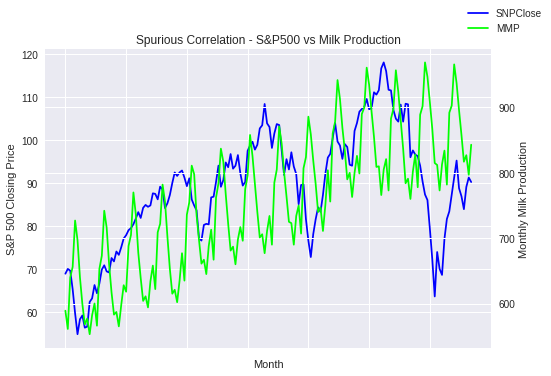

In [117]:
import matplotlib.pyplot as plt

ax = df_final.plot(x="Month", y="SNPClose", legend=False, color='blue')
ax2 = ax.twinx()
df_final.plot(x="Month", y="MMP", ax=ax2, legend=False, color="lime")
ax.set_ylabel('S&P 500 Closing Price')
ax2.set_ylabel('Monthly Milk Production')
ax.figure.legend()
plt.title("Spurious Correlation - S&P500 vs Milk Production")
plt.show()

